In [356]:
import os
import timeit
import random
import numpy as np
import pandas as pd
import graphblas as gb
from graphblas.io import mmread
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

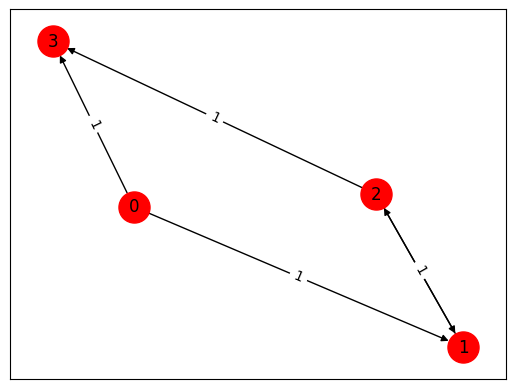

In [357]:
A = gb.Matrix.from_dense(
    [
        [0, 1, 0, 1],
        [0, 0, 1, 0],
        [0, 1, 0, 1],
        [0, 0, 0, 0],
    ], 
    missing_value=0,
)

gb.viz.draw(A)

# Functions

## MSBFS-Levels

In [358]:
def msbfs_levels(matrix, start):
    n = matrix.nrows
    start_len = len(start)

    front = Matrix(dtypes.INT32, start_len, n)
    for i, s in enumerate(start):
        front[i, s] << 1

    result = Matrix(dtypes.INT32, start_len, n)
    for i, s in enumerate(start):
        result[i, s] << 0

    for level in range(1, n-1):
        new_front = Matrix(dtypes.INT32, start_len, n)
        new_front(~result.S) << semiring.any_pair(front @ matrix)
        result(new_front.S) << level
        front(new_front.S) << 1

    result(~result.V) << -1 # устанавливаем для недостижимых вершин -1
    for i, s in enumerate(start):
        result[i, s] << 0 # опять устанавливаем для стартовой вершины 0
    
    return [
        (start_vertex, res) for start_vertex, res in zip(start, result.to_dense())
    ]

In [359]:
msbfs_levels(A, [0, 2, 3])

[(0, array([0, 1, 2, 1])),
 (2, array([-1,  1,  0,  1])),
 (3, array([-1, -1, -1,  0]))]

## MSBFS-Parents

In [360]:
def msbfs_parents(matrix, start):
    n = matrix.nrows
    ind = Vector(dtypes.UINT64, n)
    ind.build(range(n), range(n))
    results = []

    for start_vertex in start:
        parents = Vector(dtypes.INT64, n)
        parents[start_vertex] = -1
        front = Vector(dtypes.INT64, n)
        front[start_vertex] = 1

        while front.nvals > 0:
            front << ind.ewise_mult(front, binary.first)
            front(~parents.S, replace=True) << front.vxm(matrix, semiring.min_first)
            parents(binary.plus) << front

        parents_list = [parents.get(i, default=-2) for i in range(n)]
        results.append(parents_list)
        
    return [
        (start_vertex, res) for start_vertex, res in zip(start, results)
    ]

In [361]:
msbfs_parents(A, [0, 2, 3])

[(0, [-1, 0, 1, 0]), (2, [-2, 2, -1, 2]), (3, [-2, -2, -2, -1])]

## MSBFS-Levels any.pair

In [362]:
def msbfs_levels_any_pair(matrix, start):
    n = matrix.nrows
    start_len = len(start)
    result = Matrix(dtypes.INT32, start_len, n)
    front = Matrix(bool, start_len, n)
    for ind, val in enumerate(start):
        front[(ind, val)] << True
    s = Scalar(bool)
    level = -1
    while True:
        level += 1
        result(mask=front.V) << level
        front(~result.S, replace=True) << front.mxm(matrix, semiring.any_pair)
        s << front.reduce_scalar(monoid.lor)
        if not s:
            break
    
    result(~result.V) << -1 
    for i, s in enumerate(start):
        result[i, s] << 0 
    
    return [
        (start_vertex, res) for start_vertex, res in zip(start, result.to_dense())
    ]

In [363]:
msbfs_levels_any_pair(A, [0, 2, 3])

[(0, array([0, 1, 2, 1])),
 (2, array([-1,  1,  0,  1])),
 (3, array([-1, -1, -1,  0]))]

## MSBFS-Parents any.first

In [364]:
def msbfs_parents_any_first(matrix, start):
    n = matrix.nrows
    ind = Vector(dtypes.UINT64, n)
    ind.build(range(n), range(n))
    results = []

    for start_vertex in start:
        parents = Vector(dtypes.INT64, n)
        parents[start_vertex] = -1
        front = Vector(dtypes.INT64, n)
        front[start_vertex] = 1

        while front.nvals > 0:
            front << ind.ewise_mult(front, binary.first)
            front(~parents.S, replace=True) << front.vxm(matrix, semiring.any_first)
            parents(binary.plus) << front

        parents_list = [parents.get(i, default=-2) for i in range(n)]
        results.append(parents_list)
    return [
        (start_vertex, res) for start_vertex, res in zip(start, results)
    ]

In [365]:
msbfs_parents_any_first(A, [0, 2, 3])

[(0, [-1, 0, 1, 0]), (2, [-2, 2, -1, 2]), (3, [-2, -2, -2, -1])]

# Тесты

## SuiteSparse Matrix Collection

In [366]:
files = [elem for elem in os.listdir('C:/Users/Екатерина/jupyter/graph_lab/lab02/') if '.mtx' in elem]
files

['CSphd.mtx', 'EVA.mtx', 'G1.mtx', 'wb-cs-stanford.mtx']

In [367]:
real_graphs = dict()
for file_name in files[:3]:
    real_graphs[file_name.replace('.mtx', '')] = mmread(file_name)

In [368]:
algs = {
    'MSBFS-Levels': msbfs_levels,
    'MSBFS-Parents': msbfs_parents,
    'MSBFS-Levels any.pair': msbfs_levels_any_pair,
    'MSBFS-Parents any.first': msbfs_parents_any_first,
}

In [369]:
n_starts = [10, 50, 100, 300]

In [370]:
def choose_start(n_vertices, n_start):
    return random.sample(range(n_vertices), n_start)

In [372]:
for i, (graph_name, graph) in enumerate(real_graphs.items()):
    display(Markdown(f'# Graph name: {graph_name} ({i+1}/{len(real_graphs)})'))
    n_vertices = graph.shape[0]
    n_edges = len(graph.to_coo()[0])
    deg = n_edges / (n_vertices * (n_vertices - 1))
    print(
        f'Количество вершин = {n_vertices}, '
        f'количество ребер = {n_edges}, '
        f'разряженность = {round(deg, 6)}'
    )
    for alg_name, alg_func in algs.items():
        display(Markdown(f'### {alg_name}'))    
        for n_start in n_starts:
            print(f'Кол-во стартовых вершин: {n_start}')
            print(f'Time: ')
            %timeit alg_func(graph, start=choose_start(n_vertices, n_start))
            print()

# Graph name: CSphd (1/3)

Количество вершин = 1882, количество ребер = 1740, разряженность = 0.000492


### MSBFS-Levels

Кол-во стартовых вершин: 10
Time: 
141 ms ± 2.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Кол-во стартовых вершин: 50
Time: 
142 ms ± 5.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Кол-во стартовых вершин: 100
Time: 
148 ms ± 2.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Кол-во стартовых вершин: 300
Time: 
166 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)



### MSBFS-Parents

Кол-во стартовых вершин: 10
Time: 
204 ms ± 8.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Кол-во стартовых вершин: 50
Time: 
987 ms ± 23.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Кол-во стартовых вершин: 100
Time: 
1.98 s ± 62.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Кол-во стартовых вершин: 300
Time: 
5.73 s ± 82.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



### MSBFS-Levels any.pair

Кол-во стартовых вершин: 10
Time: 
850 µs ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Кол-во стартовых вершин: 50
Time: 
2.39 ms ± 59.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Кол-во стартовых вершин: 100
Time: 
4.93 ms ± 298 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Кол-во стартовых вершин: 300
Time: 
12.8 ms ± 608 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)



### MSBFS-Parents any.first

Кол-во стартовых вершин: 10
Time: 
198 ms ± 3.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Кол-во стартовых вершин: 50
Time: 
973 ms ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Кол-во стартовых вершин: 100
Time: 
1.95 s ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Кол-во стартовых вершин: 300
Time: 
5.86 s ± 130 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



# Graph name: EVA (2/3)

Количество вершин = 8497, количество ребер = 6726, разряженность = 9.3e-05


### MSBFS-Levels

Кол-во стартовых вершин: 10
Time: 
676 ms ± 87.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Кол-во стартовых вершин: 50
Time: 
646 ms ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Кол-во стартовых вершин: 100
Time: 
671 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Кол-во стартовых вершин: 300
Time: 
743 ms ± 30.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



### MSBFS-Parents

Кол-во стартовых вершин: 10
Time: 
890 ms ± 24.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Кол-во стартовых вершин: 50
Time: 
4.34 s ± 54.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Кол-во стартовых вершин: 100
Time: 
8.48 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Кол-во стартовых вершин: 300
Time: 
25.7 s ± 290 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



### MSBFS-Levels any.pair

Кол-во стартовых вершин: 10
Time: 
1.1 ms ± 22.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Кол-во стартовых вершин: 50
Time: 
6.57 ms ± 873 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Кол-во стартовых вершин: 100
Time: 
11 ms ± 359 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Кол-во стартовых вершин: 300
Time: 
33.5 ms ± 7.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)



### MSBFS-Parents any.first

Кол-во стартовых вершин: 10
Time: 
863 ms ± 4.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Кол-во стартовых вершин: 50
Time: 
4.43 s ± 88.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Кол-во стартовых вершин: 100
Time: 
8.49 s ± 183 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Кол-во стартовых вершин: 300
Time: 
24.8 s ± 177 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



# Graph name: G1 (3/3)

Количество вершин = 800, количество ребер = 38352, разряженность = 0.06


### MSBFS-Levels

Кол-во стартовых вершин: 10
Time: 
41 ms ± 817 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Кол-во стартовых вершин: 50
Time: 
43.7 ms ± 293 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Кол-во стартовых вершин: 100
Time: 
49.2 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Кол-во стартовых вершин: 300
Time: 
59.8 ms ± 737 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)



### MSBFS-Parents

Кол-во стартовых вершин: 10
Time: 
99.1 ms ± 705 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Кол-во стартовых вершин: 50
Time: 
497 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Кол-во стартовых вершин: 100
Time: 
967 ms ± 9.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Кол-во стартовых вершин: 300
Time: 
2.9 s ± 19.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



### MSBFS-Levels any.pair

Кол-во стартовых вершин: 10
Time: 
1.05 ms ± 4.36 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Кол-во стартовых вершин: 50
Time: 
3.37 ms ± 24.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Кол-во стартовых вершин: 100
Time: 
6.01 ms ± 80.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Кол-во стартовых вершин: 300
Time: 
14 ms ± 168 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)



### MSBFS-Parents any.first

Кол-во стартовых вершин: 10
Time: 
97.9 ms ± 813 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Кол-во стартовых вершин: 50
Time: 
486 ms ± 1.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Кол-во стартовых вершин: 100
Time: 
969 ms ± 9.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Кол-во стартовых вершин: 300
Time: 
3.05 s ± 207 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



## Сгенерированный граф

In [316]:
def generate_random_graph(n_vertices, n_edges):
    positions=[]
    for ind in range(n_vertices**2):
        if ind // n_vertices != ind % n_vertices:
            positions.append(ind)
    gen_indices = random.sample(positions, n_edges)
    row_indices, col_indices = np.unravel_index(gen_indices, (n_vertices, n_vertices))
    return gb.Matrix.from_coo(row_indices, col_indices, [1]*len(row_indices), nrows=n_vertices, ncols=n_vertices)

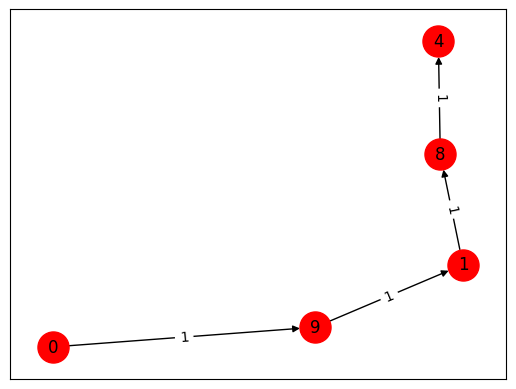

In [321]:
gb.viz.draw(generate_random_graph(10, 4))

### Кол-во вершин

In [373]:
from tqdm import tqdm

In [374]:
df_sparsity = []
df_n_vertices = []
df_alg_name = []
df_time = []
df_n_starts = []

sparsity = 0.5
start_ratio = 0.2

for n_vertices in tqdm((100, 500, 1_000, 1_500,)):
    n_edges = int((sparsity / 100) * n_vertices * (n_vertices - 1) / 2)
    graph = generate_random_graph(n_vertices, n_edges)
    n_start = int(start_ratio * n_vertices)
    for alg_name, alg_func in algs.items():
        start = choose_start(n_vertices, n_start)
        time_expr = timeit.timeit(lambda: alg_func(graph, start), number=10)
        
        df_sparsity.append(sparsity)
        df_n_vertices.append(n_vertices)
        df_alg_name.append(alg_name)
        df_time.append(time_expr)
        df_n_starts.append(n_start)
        
expr_res = pd.DataFrame(
    {
        'sparsity': df_sparsity,
        'n_vertices': df_n_vertices,
        'alg_name': df_alg_name,
        'time': df_time,
        'n_start': df_n_starts,
    }
)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:13<00:00, 48.43s/it]


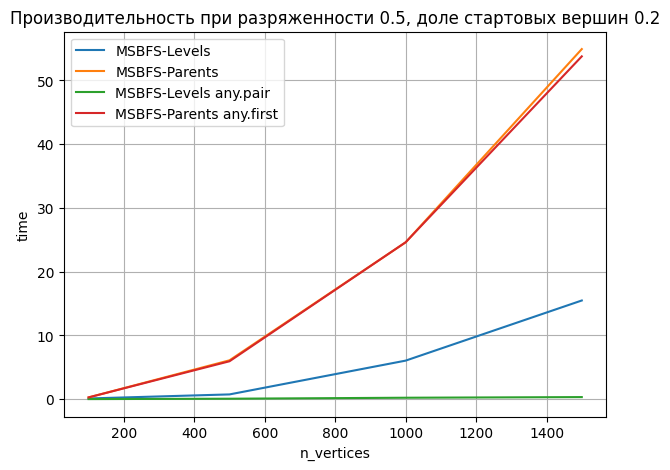

In [375]:
plt.figure(figsize=(7, 5))

for alg_name in algs.keys():
    tmp = expr_res[
        expr_res['alg_name'].eq(alg_name)
    ].sort_values('n_vertices')
    plt.plot(
        tmp['n_vertices'].values,
        tmp['time'].values,
        label=alg_name,
    )

plt.xlabel('n_vertices')
plt.ylabel('time')
plt.title(f'Производительность при разряженности {sparsity}, доле стартовых вершин {start_ratio}')
plt.legend()
plt.grid(True)
plt.show()

### Разряженность 

In [376]:
df_sparsity = []
df_n_vertices = []
df_alg_name = []
df_time = []
df_n_starts = []

start_ratio = 0.2
n_vertices = 500

for sparsity in tqdm([0.01, 0.1, 0.3, 0.5, 0.9]):
    n_edges = int((sparsity / 100) * n_vertices * (n_vertices - 1) / 2)
    graph = generate_random_graph(n_vertices, n_edges)
    n_start = int(start_ratio * n_vertices)
    for alg_name, alg_func in algs.items():
        start = choose_start(n_vertices, n_start)
        time_expr = timeit.timeit(lambda: alg_func(graph, start), number=10)
        
        df_sparsity.append(sparsity)
        df_n_vertices.append(n_vertices)
        df_alg_name.append(alg_name)
        df_time.append(time_expr)
        df_n_starts.append(n_start)
        
expr_res = pd.DataFrame(
    {
        'sparsity': df_sparsity,
        'n_vertices': df_n_vertices,
        'alg_name': df_alg_name,
        'time': df_time,
        'n_start': df_n_starts,
    }
)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:57<00:00, 11.49s/it]


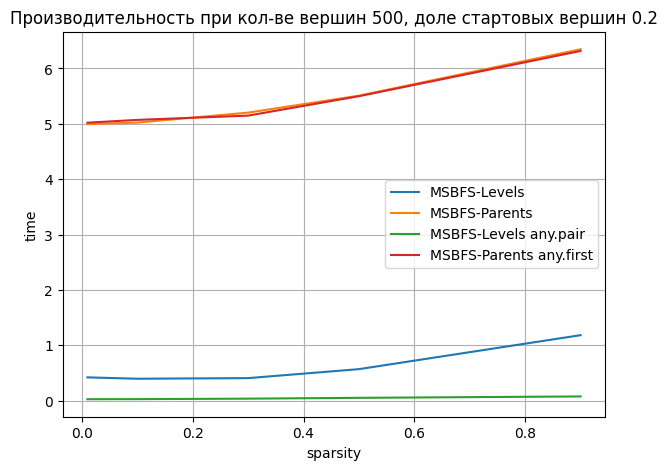

In [377]:
plt.figure(figsize=(7, 5))

for alg_name in algs.keys():
    tmp = expr_res[
        expr_res['alg_name'].eq(alg_name)
    ].sort_values('sparsity')
    plt.plot(
        tmp['sparsity'].values,
        tmp['time'].values,
        label=alg_name,
    )

plt.xlabel('sparsity')
plt.ylabel('time')
plt.title(f'Производительность при кол-ве вершин {n_vertices}, доле стартовых вершин {start_ratio}')
plt.legend()
plt.grid(True)
plt.show()

### Кол-во стартовых точек

In [378]:
df_sparsity = []
df_n_vertices = []
df_alg_name = []
df_time = []
df_n_starts = []

sparsity = 0.5
n_vertices = 500

n_edges = int((sparsity / 100) * n_vertices * (n_vertices - 1) / 2)
graph = generate_random_graph(n_vertices, n_edges)
for start_ratio in tqdm([0.05, 0.1, 0.3, 0.5, 0.8]):
    n_start = int(start_ratio * n_vertices)
    start = choose_start(n_vertices, n_start)
    for alg_name, alg_func in algs.items():
        time_expr = timeit.timeit(lambda: alg_func(graph, start), number=10)

        df_sparsity.append(sparsity)
        df_n_vertices.append(n_vertices)
        df_alg_name.append(alg_name)
        df_time.append(time_expr)
        df_n_starts.append(n_start)
        
expr_res = pd.DataFrame(
    {
        'sparsity': df_sparsity,
        'n_vertices': df_n_vertices,
        'alg_name': df_alg_name,
        'time': df_time,
        'n_start': df_n_starts,
    }
)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:44<00:00, 20.88s/it]


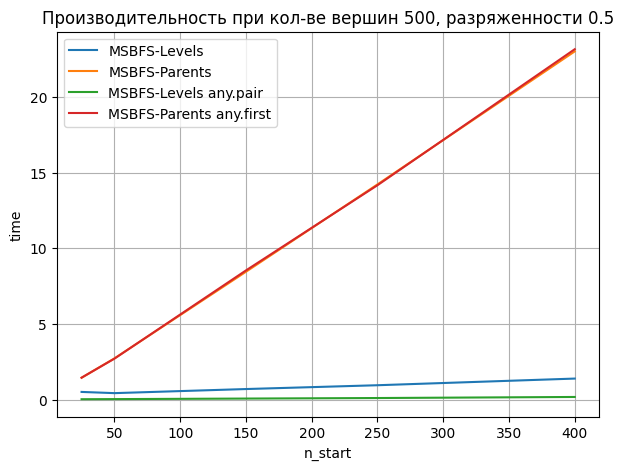

In [379]:
plt.figure(figsize=(7, 5))

for alg_name in algs.keys():
    tmp = expr_res[
        expr_res['alg_name'].eq(alg_name)
    ].sort_values('n_start')
    plt.plot(
        tmp['n_start'].values,
        tmp['time'].values,
        label=alg_name,
    )

plt.xlabel('n_start')
plt.ylabel('time')
plt.title(f'Производительность при кол-ве вершин {n_vertices}, разряженности {sparsity}')
plt.legend()
plt.grid(True)
plt.show()

# Выводы

- С ростом числа вершин увеличивается время работы алгоритмов увеличивается (при степени разреженности = 0.5 и числе стартовых вершин = 20%)
- При увеличении степени разреженности время работы алгоритмов увеличивается (при числе  вершин = 500 и числе стартовых вершин = 20%)
- С ростом числа стартовых вершин  время работы алгоритмов увеличивается (при степени разреженности = 0.5 и числе  вершин = 500)
- Алгоритмы MSBFS-Levels и MSBFS-Levels any.pair работают быстрее чем MSBFS-Parents и MSBFS-Parents any.first при усложнении графа (разряженность, кол-во вершин) и при увеличении кол-ва стартовых точек